In [1]:
!pip install transformers==3.4.0

     |████████████████████████████████| 1.3 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 8.3 MB/s eta 0:00:01
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.4.0 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import transformers
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
import matplotlib.pyplot as plt
import numpy as np

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [4]:
train = pd.read_csv('../input/dataset-modified/train_modified.csv')
valid = pd.read_csv('../input/dataset-modified/val_modified.csv')
test = pd.read_csv('../input/dataset-modified/test_modified.csv')

xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [5]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = 'bert-base-multilingual-cased')
max_len = 200

xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [6]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(SGD(lr=0.01), loss=loss, metrics=['accuracy'])

    return model

In [7]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_name = 'bert-base-multilingual-cased'
    config = BertConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    model = build_model(transformer_model)
    
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 200, 768), (None, 177853440 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3076      
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32) 

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 1.4289 - accuracy: 0.15 - ETA: 2s - loss: 1.4324 - accuracy: 0.18 - ETA: 3s - loss: 1.4185 - accuracy: 0.23 - ETA: 4s - loss: 1.4345 - accuracy: 0.23 - ETA: 4s - loss: 1.4513 - accuracy: 0.20 - ETA: 4s - loss: 1.4579 - accuracy: 0.20 - ETA: 4s - loss: 1.4517 - accuracy: 0.21 - ETA: 4s - loss: 1.4611 - accuracy: 0.19 - ETA: 5s - loss: 1.4596 - accuracy: 0.19 - ETA: 5s - loss: 1.4514 - accuracy: 0.21 - ETA: 5s - loss: 1.4499 - accuracy: 0.21 - ETA: 5s - loss: 1.4475 - accuracy: 0.21 - ETA: 5s - loss: 1.4425 - accuracy: 0.21 - ETA: 5s - loss: 1.4391 - accuracy: 0.21 - ETA: 5s - loss: 1.4377 - accuracy: 0.21 - ETA: 5s - loss: 1.4381 - accuracy: 0.21 - ETA: 5s - loss: 1.4374 - accuracy: 0.21 - ETA: 5s - loss: 1.4318 - accuracy: 0.22 - ETA: 4s - loss: 1.4304 - accuracy: 0.23 - ETA: 4s - loss: 1.4290 - accuracy: 0.23 - ETA: 4s - loss: 1.4288 - accuracy: 0.23 - ETA: 4s - loss: 1.4273 - accuracy: 0.23 - ETA: 4s - loss: 1.4255 

Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.3762 - accuracy: 0.31 - ETA: 2s - loss: 1.3759 - accuracy: 0.34 - ETA: 3s - loss: 1.3804 - accuracy: 0.30 - ETA: 4s - loss: 1.3804 - accuracy: 0.28 - ETA: 4s - loss: 1.3838 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.26 - ETA: 4s - loss: 1.3865 - accuracy: 0.26 - ETA: 4s - loss: 1.3869 - accuracy: 0.25 - ETA: 4s - loss: 1.3861 - accuracy: 0.25 - ETA: 4s - loss: 1.3872 - accuracy: 0.24 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3887 - accuracy: 0.25 - ETA: 4s - loss: 1.3883 - accuracy: 0.25 - ETA: 4s - loss: 1.3879 - accuracy: 0.25 - ETA: 4s - loss: 1.3874 - accuracy: 0.25 - ETA: 4s - loss: 1.3867 - accuracy: 0.25 - ETA: 4s - loss: 1.3850 - accuracy: 0.26 - ETA: 4s - loss: 1.3859 - accuracy: 0.26 - ETA: 4s - loss: 1.3869 - accuracy: 0.25 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3872 - accuracy: 0.25 - ETA: 4s - loss: 1.3867 

94/94 [==============================] - ETA: 0s - loss: 1.3907 - accuracy: 0.18 - ETA: 2s - loss: 1.3966 - accuracy: 0.18 - ETA: 3s - loss: 1.3881 - accuracy: 0.26 - ETA: 4s - loss: 1.3877 - accuracy: 0.25 - ETA: 4s - loss: 1.3893 - accuracy: 0.25 - ETA: 4s - loss: 1.3862 - accuracy: 0.27 - ETA: 4s - loss: 1.3824 - accuracy: 0.29 - ETA: 4s - loss: 1.3919 - accuracy: 0.26 - ETA: 4s - loss: 1.3932 - accuracy: 0.25 - ETA: 4s - loss: 1.3938 - accuracy: 0.25 - ETA: 4s - loss: 1.3931 - accuracy: 0.26 - ETA: 4s - loss: 1.3935 - accuracy: 0.26 - ETA: 4s - loss: 1.3909 - accuracy: 0.27 - ETA: 4s - loss: 1.3899 - accuracy: 0.27 - ETA: 4s - loss: 1.3915 - accuracy: 0.26 - ETA: 4s - loss: 1.3893 - accuracy: 0.27 - ETA: 4s - loss: 1.3886 - accuracy: 0.27 - ETA: 4s - loss: 1.3884 - accuracy: 0.27 - ETA: 4s - loss: 1.3904 - accuracy: 0.26 - ETA: 4s - loss: 1.3907 - accuracy: 0.26 - ETA: 4s - loss: 1.3905 - accuracy: 0.26 - ETA: 4s - loss: 1.3910 - accuracy: 0.25 - ETA: 4s - loss: 1.3911 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.21 - ETA: 2s - loss: 1.3825 - accuracy: 0.28 - ETA: 3s - loss: 1.3890 - accuracy: 0.28 - ETA: 4s - loss: 1.3878 - accuracy: 0.26 - ETA: 4s - loss: 1.3905 - accuracy: 0.24 - ETA: 4s - loss: 1.3906 - accuracy: 0.23 - ETA: 4s - loss: 1.3868 - accuracy: 0.25 - ETA: 4s - loss: 1.3866 - accuracy: 0.26 - ETA: 4s - loss: 1.3853 - accuracy: 0.26 - ETA: 4s - loss: 1.3859 - accuracy: 0.27 - ETA: 4s - loss: 1.3833 - accuracy: 0.27 - ETA: 4s - loss: 1.3831 - accuracy: 0.27 - ETA: 4s - loss: 1.3821 - accuracy: 0.26 - ETA: 4s - loss: 1.3819 - accuracy: 0.27 - ETA: 4s - loss: 1.3831 - accuracy: 0.26 - ETA: 4s - loss: 1.3851 - accuracy: 0.25 - ETA: 4s - loss: 1.3832 - accuracy: 0.26 - ETA: 4s - loss: 1.3808 - accuracy: 0.27 - ETA: 4s - loss: 1.3803 - accuracy: 0.27 - ETA: 4s - loss: 1.3801 - accuracy: 0.27 - ETA: 4s - loss: 1.3785 - accuracy: 0.28 - ETA: 4s - loss: 1.3778 - accuracy: 0.28 - ETA: 4s - loss: 1.3771 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 1.0897 - accuracy: 0.62 - ETA: 2s - loss: 1.1321 - accuracy: 0.62 - ETA: 3s - loss: 1.1524 - accuracy: 0.58 - ETA: 6s - loss: 1.1388 - accuracy: 0.60 - ETA: 7s - loss: 1.1670 - accuracy: 0.56 - ETA: 6s - loss: 1.1544 - accuracy: 0.58 - ETA: 6s - loss: 1.1450 - accuracy: 0.59 - ETA: 6s - loss: 1.1404 - accuracy: 0.59 - ETA: 6s - loss: 1.1360 - accuracy: 0.59 - ETA: 5s - loss: 1.1358 - accuracy: 0.59 - ETA: 5s - loss: 1.1416 - accuracy: 0.58 - ETA: 5s - loss: 1.1471 - accuracy: 0.57 - ETA: 5s - loss: 1.1489 - accuracy: 0.57 - ETA: 5s - loss: 1.1534 - accuracy: 0.57 - ETA: 5s - loss: 1.1433 - accuracy: 0.58 - ETA: 5s - loss: 1.1335 - accuracy: 0.59 - ETA: 5s - loss: 1.1263 - accuracy: 0.60 - ETA: 5s - loss: 1.1265 - accuracy: 0.60 - ETA: 5s - loss: 1.1305 - accuracy: 0.60 - ETA: 4s - loss: 1.1279 - accuracy: 0.60 - ETA: 4s - loss: 1.1260 - accuracy: 0.61 - ETA: 4s - loss: 1.1232 - accuracy: 0.61 - ETA: 4s - loss: 1.1265 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.75 - ETA: 2s - loss: 1.0291 - accuracy: 0.71 - ETA: 3s - loss: 1.0044 - accuracy: 0.73 - ETA: 4s - loss: 0.9944 - accuracy: 0.75 - ETA: 4s - loss: 1.0007 - accuracy: 0.74 - ETA: 4s - loss: 0.9752 - accuracy: 0.77 - ETA: 4s - loss: 0.9531 - accuracy: 0.79 - ETA: 4s - loss: 0.9515 - accuracy: 0.79 - ETA: 4s - loss: 0.9615 - accuracy: 0.78 - ETA: 4s - loss: 0.9541 - accuracy: 0.79 - ETA: 4s - loss: 0.9629 - accuracy: 0.78 - ETA: 4s - loss: 0.9611 - accuracy: 0.78 - ETA: 4s - loss: 0.9583 - accuracy: 0.78 - ETA: 4s - loss: 0.9538 - accuracy: 0.79 - ETA: 4s - loss: 0.9545 - accuracy: 0.78 - ETA: 4s - loss: 0.9446 - accuracy: 0.80 - ETA: 4s - loss: 0.9487 - accuracy: 0.79 - ETA: 4s - loss: 0.9536 - accuracy: 0.78 - ETA: 4s - loss: 0.9577 - accuracy: 0.78 - ETA: 4s - loss: 0.9579 - accuracy: 0.78 - ETA: 4s - loss: 0.9574 - accuracy: 0.78 - ETA: 4s - loss: 0.9545 - accuracy: 0.78 - ETA: 4s - loss: 0.9560 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.78 - ETA: 2s - loss: 1.0089 - accuracy: 0.73 - ETA: 3s - loss: 0.9779 - accuracy: 0.76 - ETA: 4s - loss: 0.9646 - accuracy: 0.77 - ETA: 4s - loss: 0.9655 - accuracy: 0.77 - ETA: 4s - loss: 0.9646 - accuracy: 0.77 - ETA: 4s - loss: 0.9654 - accuracy: 0.77 - ETA: 4s - loss: 0.9560 - accuracy: 0.78 - ETA: 4s - loss: 0.9539 - accuracy: 0.79 - ETA: 4s - loss: 0.9562 - accuracy: 0.78 - ETA: 4s - loss: 0.9571 - accuracy: 0.78 - ETA: 4s - loss: 0.9522 - accuracy: 0.78 - ETA: 4s - loss: 0.9509 - accuracy: 0.79 - ETA: 4s - loss: 0.9578 - accuracy: 0.78 - ETA: 4s - loss: 0.9649 - accuracy: 0.77 - ETA: 4s - loss: 0.9641 - accuracy: 0.77 - ETA: 4s - loss: 0.9593 - accuracy: 0.78 - ETA: 4s - loss: 0.9581 - accuracy: 0.78 - ETA: 4s - loss: 0.9612 - accuracy: 0.77 - ETA: 4s - loss: 0.9642 - accuracy: 0.77 - ETA: 4s - loss: 0.9705 - accuracy: 0.76 - ETA: 4s - loss: 0.9659 - accuracy: 0.77 - ETA: 4s - loss: 0.9616 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8938 - accuracy: 0.84 - ETA: 2s - loss: 0.8790 - accuracy: 0.87 - ETA: 3s - loss: 0.8904 - accuracy: 0.85 - ETA: 4s - loss: 0.8799 - accuracy: 0.86 - ETA: 4s - loss: 0.8674 - accuracy: 0.87 - ETA: 4s - loss: 0.8779 - accuracy: 0.86 - ETA: 4s - loss: 0.8836 - accuracy: 0.87 - ETA: 4s - loss: 0.8832 - accuracy: 0.86 - ETA: 4s - loss: 0.8844 - accuracy: 0.86 - ETA: 4s - loss: 0.9034 - accuracy: 0.84 - ETA: 4s - loss: 0.8982 - accuracy: 0.85 - ETA: 4s - loss: 0.9022 - accuracy: 0.84 - ETA: 4s - loss: 0.9164 - accuracy: 0.83 - ETA: 4s - loss: 0.9237 - accuracy: 0.82 - ETA: 4s - loss: 0.9252 - accuracy: 0.82 - ETA: 4s - loss: 0.9180 - accuracy: 0.83 - ETA: 4s - loss: 0.9139 - accuracy: 0.83 - ETA: 4s - loss: 0.9152 - accuracy: 0.83 - ETA: 4s - loss: 0.9114 - accuracy: 0.83 - ETA: 4s - loss: 0.9123 - accuracy: 0.83 - ETA: 4s - loss: 0.9123 - accuracy: 0.83 - ETA: 4s - loss: 0.9117 - accuracy: 0.83 - ETA: 4s - loss: 0.9169 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.9063 - accuracy: 0.81 - ETA: 2s - loss: 0.8846 - accuracy: 0.84 - ETA: 3s - loss: 0.8587 - accuracy: 0.87 - ETA: 4s - loss: 0.8874 - accuracy: 0.85 - ETA: 4s - loss: 0.9201 - accuracy: 0.81 - ETA: 4s - loss: 0.9164 - accuracy: 0.82 - ETA: 4s - loss: 0.9146 - accuracy: 0.82 - ETA: 4s - loss: 0.9146 - accuracy: 0.82 - ETA: 4s - loss: 0.9109 - accuracy: 0.82 - ETA: 4s - loss: 0.9011 - accuracy: 0.84 - ETA: 4s - loss: 0.8968 - accuracy: 0.84 - ETA: 4s - loss: 0.8899 - accuracy: 0.85 - ETA: 4s - loss: 0.8885 - accuracy: 0.85 - ETA: 4s - loss: 0.8908 - accuracy: 0.85 - ETA: 4s - loss: 0.8984 - accuracy: 0.84 - ETA: 4s - loss: 0.8977 - accuracy: 0.84 - ETA: 4s - loss: 0.8901 - accuracy: 0.85 - ETA: 4s - loss: 0.8883 - accuracy: 0.85 - ETA: 4s - loss: 0.8890 - accuracy: 0.85 - ETA: 4s - loss: 0.8893 - accuracy: 0.85 - ETA: 4s - loss: 0.8910 - accuracy: 0.85 - ETA: 4s - loss: 0.8868 - accuracy: 0.85 - ETA: 4s - loss: 0.8877 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.90 - ETA: 2s - loss: 0.8504 - accuracy: 0.92 - ETA: 3s - loss: 0.8659 - accuracy: 0.88 - ETA: 4s - loss: 0.8441 - accuracy: 0.90 - ETA: 4s - loss: 0.8530 - accuracy: 0.90 - ETA: 4s - loss: 0.8535 - accuracy: 0.90 - ETA: 4s - loss: 0.8587 - accuracy: 0.89 - ETA: 4s - loss: 0.8638 - accuracy: 0.88 - ETA: 4s - loss: 0.8620 - accuracy: 0.88 - ETA: 4s - loss: 0.8541 - accuracy: 0.89 - ETA: 4s - loss: 0.8602 - accuracy: 0.88 - ETA: 4s - loss: 0.8612 - accuracy: 0.88 - ETA: 4s - loss: 0.8597 - accuracy: 0.88 - ETA: 4s - loss: 0.8602 - accuracy: 0.88 - ETA: 4s - loss: 0.8567 - accuracy: 0.89 - ETA: 4s - loss: 0.8550 - accuracy: 0.89 - ETA: 4s - loss: 0.8527 - accuracy: 0.89 - ETA: 4s - loss: 0.8568 - accuracy: 0.89 - ETA: 4s - loss: 0.8563 - accuracy: 0.89 - ETA: 4s - loss: 0.8524 - accuracy: 0.89 - ETA: 4s - loss: 0.8502 - accuracy: 0.89 - ETA: 4s - loss: 0.8568 - accuracy: 0.89 - ETA: 4s - loss: 0.8636 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.87 - ETA: 2s - loss: 0.9328 - accuracy: 0.82 - ETA: 3s - loss: 0.8751 - accuracy: 0.88 - ETA: 4s - loss: 0.8727 - accuracy: 0.88 - ETA: 4s - loss: 0.8776 - accuracy: 0.87 - ETA: 4s - loss: 0.8661 - accuracy: 0.88 - ETA: 4s - loss: 0.8580 - accuracy: 0.89 - ETA: 4s - loss: 0.8503 - accuracy: 0.89 - ETA: 4s - loss: 0.8552 - accuracy: 0.89 - ETA: 4s - loss: 0.8557 - accuracy: 0.89 - ETA: 4s - loss: 0.8588 - accuracy: 0.88 - ETA: 4s - loss: 0.8623 - accuracy: 0.88 - ETA: 4s - loss: 0.8604 - accuracy: 0.88 - ETA: 4s - loss: 0.8588 - accuracy: 0.88 - ETA: 4s - loss: 0.8563 - accuracy: 0.88 - ETA: 4s - loss: 0.8653 - accuracy: 0.87 - ETA: 4s - loss: 0.8658 - accuracy: 0.87 - ETA: 4s - loss: 0.8643 - accuracy: 0.88 - ETA: 4s - loss: 0.8615 - accuracy: 0.88 - ETA: 4s - loss: 0.8620 - accuracy: 0.88 - ETA: 4s - loss: 0.8604 - accuracy: 0.88 - ETA: 4s - loss: 0.8594 - accuracy: 0.88 - ETA: 4s - loss: 0.8596 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.96 - ETA: 2s - loss: 0.8146 - accuracy: 0.92 - ETA: 3s - loss: 0.8427 - accuracy: 0.89 - ETA: 4s - loss: 0.8240 - accuracy: 0.91 - ETA: 4s - loss: 0.8260 - accuracy: 0.91 - ETA: 4s - loss: 0.8293 - accuracy: 0.91 - ETA: 4s - loss: 0.8248 - accuracy: 0.91 - ETA: 4s - loss: 0.8168 - accuracy: 0.92 - ETA: 4s - loss: 0.8172 - accuracy: 0.92 - ETA: 4s - loss: 0.8140 - accuracy: 0.93 - ETA: 4s - loss: 0.8155 - accuracy: 0.93 - ETA: 4s - loss: 0.8175 - accuracy: 0.92 - ETA: 4s - loss: 0.8190 - accuracy: 0.92 - ETA: 4s - loss: 0.8222 - accuracy: 0.92 - ETA: 4s - loss: 0.8219 - accuracy: 0.92 - ETA: 4s - loss: 0.8249 - accuracy: 0.91 - ETA: 4s - loss: 0.8210 - accuracy: 0.92 - ETA: 4s - loss: 0.8219 - accuracy: 0.92 - ETA: 4s - loss: 0.8196 - accuracy: 0.92 - ETA: 4s - loss: 0.8209 - accuracy: 0.92 - ETA: 4s - loss: 0.8246 - accuracy: 0.92 - ETA: 4s - loss: 0.8249 - accuracy: 0.92 - ETA: 4s - loss: 0.8242 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.93 - ETA: 2s - loss: 0.7921 - accuracy: 0.95 - ETA: 3s - loss: 0.8172 - accuracy: 0.92 - ETA: 4s - loss: 0.8093 - accuracy: 0.93 - ETA: 4s - loss: 0.7964 - accuracy: 0.95 - ETA: 4s - loss: 0.7981 - accuracy: 0.94 - ETA: 4s - loss: 0.7993 - accuracy: 0.94 - ETA: 4s - loss: 0.8111 - accuracy: 0.93 - ETA: 4s - loss: 0.8223 - accuracy: 0.92 - ETA: 4s - loss: 0.8236 - accuracy: 0.92 - ETA: 4s - loss: 0.8242 - accuracy: 0.92 - ETA: 4s - loss: 0.8303 - accuracy: 0.91 - ETA: 4s - loss: 0.8264 - accuracy: 0.91 - ETA: 4s - loss: 0.8292 - accuracy: 0.91 - ETA: 4s - loss: 0.8277 - accuracy: 0.91 - ETA: 4s - loss: 0.8307 - accuracy: 0.91 - ETA: 4s - loss: 0.8294 - accuracy: 0.91 - ETA: 4s - loss: 0.8312 - accuracy: 0.91 - ETA: 4s - loss: 0.8298 - accuracy: 0.91 - ETA: 4s - loss: 0.8300 - accuracy: 0.91 - ETA: 4s - loss: 0.8308 - accuracy: 0.91 - ETA: 4s - loss: 0.8329 - accuracy: 0.91 - ETA: 4s - loss: 0.8322 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.90 - ETA: 2s - loss: 0.8484 - accuracy: 0.89 - ETA: 3s - loss: 0.8412 - accuracy: 0.89 - ETA: 5s - loss: 0.8403 - accuracy: 0.89 - ETA: 6s - loss: 0.8302 - accuracy: 0.91 - ETA: 6s - loss: 0.8421 - accuracy: 0.90 - ETA: 6s - loss: 0.8322 - accuracy: 0.91 - ETA: 6s - loss: 0.8304 - accuracy: 0.91 - ETA: 5s - loss: 0.8209 - accuracy: 0.92 - ETA: 5s - loss: 0.8246 - accuracy: 0.91 - ETA: 5s - loss: 0.8206 - accuracy: 0.92 - ETA: 5s - loss: 0.8277 - accuracy: 0.91 - ETA: 5s - loss: 0.8215 - accuracy: 0.92 - ETA: 5s - loss: 0.8253 - accuracy: 0.91 - ETA: 5s - loss: 0.8268 - accuracy: 0.91 - ETA: 5s - loss: 0.8275 - accuracy: 0.91 - ETA: 5s - loss: 0.8248 - accuracy: 0.92 - ETA: 5s - loss: 0.8256 - accuracy: 0.92 - ETA: 4s - loss: 0.8229 - accuracy: 0.92 - ETA: 4s - loss: 0.8269 - accuracy: 0.91 - ETA: 4s - loss: 0.8245 - accuracy: 0.92 - ETA: 4s - loss: 0.8251 - accuracy: 0.92 - ETA: 4s - loss: 0.8243 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.96 - ETA: 2s - loss: 0.7837 - accuracy: 0.95 - ETA: 3s - loss: 0.8068 - accuracy: 0.93 - ETA: 4s - loss: 0.7989 - accuracy: 0.94 - ETA: 4s - loss: 0.8051 - accuracy: 0.93 - ETA: 4s - loss: 0.8052 - accuracy: 0.93 - ETA: 4s - loss: 0.8143 - accuracy: 0.92 - ETA: 4s - loss: 0.8140 - accuracy: 0.92 - ETA: 4s - loss: 0.8151 - accuracy: 0.92 - ETA: 4s - loss: 0.8129 - accuracy: 0.92 - ETA: 4s - loss: 0.8128 - accuracy: 0.92 - ETA: 4s - loss: 0.8142 - accuracy: 0.92 - ETA: 4s - loss: 0.8112 - accuracy: 0.93 - ETA: 4s - loss: 0.8151 - accuracy: 0.92 - ETA: 4s - loss: 0.8107 - accuracy: 0.93 - ETA: 4s - loss: 0.8104 - accuracy: 0.93 - ETA: 4s - loss: 0.8066 - accuracy: 0.93 - ETA: 4s - loss: 0.8050 - accuracy: 0.93 - ETA: 4s - loss: 0.8067 - accuracy: 0.93 - ETA: 4s - loss: 0.8067 - accuracy: 0.93 - ETA: 4s - loss: 0.8070 - accuracy: 0.93 - ETA: 4s - loss: 0.8056 - accuracy: 0.93 - ETA: 4s - loss: 0.8044 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8332 - accuracy: 0.90 - ETA: 2s - loss: 0.8148 - accuracy: 0.92 - ETA: 3s - loss: 0.8308 - accuracy: 0.90 - ETA: 4s - loss: 0.8179 - accuracy: 0.92 - ETA: 4s - loss: 0.8098 - accuracy: 0.93 - ETA: 4s - loss: 0.7989 - accuracy: 0.94 - ETA: 4s - loss: 0.8044 - accuracy: 0.93 - ETA: 4s - loss: 0.8048 - accuracy: 0.93 - ETA: 4s - loss: 0.8034 - accuracy: 0.93 - ETA: 4s - loss: 0.8017 - accuracy: 0.94 - ETA: 4s - loss: 0.8076 - accuracy: 0.93 - ETA: 4s - loss: 0.8037 - accuracy: 0.93 - ETA: 4s - loss: 0.8016 - accuracy: 0.93 - ETA: 4s - loss: 0.8005 - accuracy: 0.94 - ETA: 4s - loss: 0.8008 - accuracy: 0.94 - ETA: 4s - loss: 0.8054 - accuracy: 0.93 - ETA: 4s - loss: 0.8028 - accuracy: 0.94 - ETA: 4s - loss: 0.8014 - accuracy: 0.94 - ETA: 4s - loss: 0.8023 - accuracy: 0.94 - ETA: 4s - loss: 0.8044 - accuracy: 0.94 - ETA: 4s - loss: 0.8040 - accuracy: 0.94 - ETA: 4s - loss: 0.8033 - accuracy: 0.94 - ETA: 4s - loss: 0.8018 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8422 - accuracy: 0.90 - ETA: 2s - loss: 0.8366 - accuracy: 0.90 - ETA: 3s - loss: 0.8301 - accuracy: 0.91 - ETA: 4s - loss: 0.8484 - accuracy: 0.89 - ETA: 4s - loss: 0.8390 - accuracy: 0.90 - ETA: 4s - loss: 0.8275 - accuracy: 0.92 - ETA: 4s - loss: 0.8277 - accuracy: 0.91 - ETA: 4s - loss: 0.8250 - accuracy: 0.92 - ETA: 4s - loss: 0.8230 - accuracy: 0.92 - ETA: 4s - loss: 0.8238 - accuracy: 0.92 - ETA: 4s - loss: 0.8212 - accuracy: 0.92 - ETA: 4s - loss: 0.8208 - accuracy: 0.92 - ETA: 4s - loss: 0.8247 - accuracy: 0.91 - ETA: 4s - loss: 0.8215 - accuracy: 0.91 - ETA: 4s - loss: 0.8185 - accuracy: 0.92 - ETA: 4s - loss: 0.8157 - accuracy: 0.92 - ETA: 4s - loss: 0.8150 - accuracy: 0.92 - ETA: 4s - loss: 0.8127 - accuracy: 0.92 - ETA: 5s - loss: 0.8127 - accuracy: 0.92 - ETA: 4s - loss: 0.8126 - accuracy: 0.92 - ETA: 4s - loss: 0.8154 - accuracy: 0.92 - ETA: 4s - loss: 0.8151 - accuracy: 0.92 - ETA: 4s - loss: 0.8124 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.93 - ETA: 2s - loss: 0.7893 - accuracy: 0.95 - ETA: 3s - loss: 0.8061 - accuracy: 0.93 - ETA: 4s - loss: 0.8257 - accuracy: 0.91 - ETA: 4s - loss: 0.8230 - accuracy: 0.91 - ETA: 4s - loss: 0.8099 - accuracy: 0.93 - ETA: 4s - loss: 0.8052 - accuracy: 0.93 - ETA: 4s - loss: 0.8059 - accuracy: 0.93 - ETA: 4s - loss: 0.8093 - accuracy: 0.93 - ETA: 4s - loss: 0.8060 - accuracy: 0.93 - ETA: 4s - loss: 0.8050 - accuracy: 0.93 - ETA: 4s - loss: 0.8012 - accuracy: 0.94 - ETA: 4s - loss: 0.8016 - accuracy: 0.93 - ETA: 4s - loss: 0.8042 - accuracy: 0.93 - ETA: 4s - loss: 0.8050 - accuracy: 0.93 - ETA: 4s - loss: 0.8068 - accuracy: 0.93 - ETA: 4s - loss: 0.8088 - accuracy: 0.93 - ETA: 4s - loss: 0.8121 - accuracy: 0.93 - ETA: 4s - loss: 0.8090 - accuracy: 0.93 - ETA: 4s - loss: 0.8088 - accuracy: 0.93 - ETA: 4s - loss: 0.8057 - accuracy: 0.93 - ETA: 4s - loss: 0.8058 - accuracy: 0.93 - ETA: 4s - loss: 0.8071 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.93 - ETA: 2s - loss: 0.8790 - accuracy: 0.85 - ETA: 3s - loss: 0.8443 - accuracy: 0.89 - ETA: 4s - loss: 0.8523 - accuracy: 0.89 - ETA: 4s - loss: 0.8440 - accuracy: 0.90 - ETA: 4s - loss: 0.8355 - accuracy: 0.90 - ETA: 4s - loss: 0.8314 - accuracy: 0.91 - ETA: 4s - loss: 0.8328 - accuracy: 0.91 - ETA: 4s - loss: 0.8298 - accuracy: 0.91 - ETA: 4s - loss: 0.8274 - accuracy: 0.91 - ETA: 4s - loss: 0.8226 - accuracy: 0.92 - ETA: 4s - loss: 0.8189 - accuracy: 0.92 - ETA: 4s - loss: 0.8180 - accuracy: 0.92 - ETA: 4s - loss: 0.8213 - accuracy: 0.92 - ETA: 4s - loss: 0.8179 - accuracy: 0.92 - ETA: 4s - loss: 0.8173 - accuracy: 0.92 - ETA: 4s - loss: 0.8149 - accuracy: 0.92 - ETA: 4s - loss: 0.8128 - accuracy: 0.93 - ETA: 4s - loss: 0.8108 - accuracy: 0.93 - ETA: 4s - loss: 0.8103 - accuracy: 0.93 - ETA: 4s - loss: 0.8117 - accuracy: 0.93 - ETA: 4s - loss: 0.8128 - accuracy: 0.93 - ETA: 4s - loss: 0.8099 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.8011 - accuracy: 0.93 - ETA: 3s - loss: 0.7929 - accuracy: 0.94 - ETA: 4s - loss: 0.8111 - accuracy: 0.92 - ETA: 4s - loss: 0.8035 - accuracy: 0.93 - ETA: 4s - loss: 0.8028 - accuracy: 0.93 - ETA: 4s - loss: 0.7993 - accuracy: 0.94 - ETA: 4s - loss: 0.7964 - accuracy: 0.94 - ETA: 4s - loss: 0.7973 - accuracy: 0.94 - ETA: 4s - loss: 0.8012 - accuracy: 0.94 - ETA: 4s - loss: 0.8044 - accuracy: 0.93 - ETA: 4s - loss: 0.7995 - accuracy: 0.94 - ETA: 4s - loss: 0.7955 - accuracy: 0.94 - ETA: 4s - loss: 0.7984 - accuracy: 0.94 - ETA: 4s - loss: 0.7990 - accuracy: 0.94 - ETA: 4s - loss: 0.7994 - accuracy: 0.94 - ETA: 4s - loss: 0.8000 - accuracy: 0.94 - ETA: 4s - loss: 0.7993 - accuracy: 0.94 - ETA: 4s - loss: 0.7996 - accuracy: 0.94 - ETA: 4s - loss: 0.8033 - accuracy: 0.94 - ETA: 4s - loss: 0.8046 - accuracy: 0.93 - ETA: 4s - loss: 0.8033 - accuracy: 0.94 - ETA: 4s - loss: 0.8034 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.93 - ETA: 2s - loss: 0.8034 - accuracy: 0.93 - ETA: 3s - loss: 0.7934 - accuracy: 0.94 - ETA: 4s - loss: 0.7967 - accuracy: 0.94 - ETA: 4s - loss: 0.7923 - accuracy: 0.95 - ETA: 4s - loss: 0.7844 - accuracy: 0.95 - ETA: 4s - loss: 0.7869 - accuracy: 0.95 - ETA: 4s - loss: 0.7855 - accuracy: 0.95 - ETA: 4s - loss: 0.7881 - accuracy: 0.95 - ETA: 4s - loss: 0.7888 - accuracy: 0.95 - ETA: 4s - loss: 0.7880 - accuracy: 0.95 - ETA: 4s - loss: 0.7847 - accuracy: 0.95 - ETA: 4s - loss: 0.7817 - accuracy: 0.96 - ETA: 4s - loss: 0.7858 - accuracy: 0.95 - ETA: 5s - loss: 0.7871 - accuracy: 0.95 - ETA: 5s - loss: 0.7885 - accuracy: 0.95 - ETA: 5s - loss: 0.7906 - accuracy: 0.95 - ETA: 5s - loss: 0.7910 - accuracy: 0.95 - ETA: 5s - loss: 0.7901 - accuracy: 0.95 - ETA: 4s - loss: 0.7914 - accuracy: 0.95 - ETA: 4s - loss: 0.7936 - accuracy: 0.94 - ETA: 4s - loss: 0.7914 - accuracy: 0.95 - ETA: 4s - loss: 0.7919 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.96 - ETA: 2s - loss: 0.7754 - accuracy: 0.96 - ETA: 3s - loss: 0.7842 - accuracy: 0.95 - ETA: 4s - loss: 0.7836 - accuracy: 0.96 - ETA: 4s - loss: 0.7882 - accuracy: 0.95 - ETA: 4s - loss: 0.7808 - accuracy: 0.96 - ETA: 4s - loss: 0.7888 - accuracy: 0.95 - ETA: 4s - loss: 0.7834 - accuracy: 0.96 - ETA: 4s - loss: 0.7837 - accuracy: 0.96 - ETA: 4s - loss: 0.7807 - accuracy: 0.96 - ETA: 4s - loss: 0.7807 - accuracy: 0.96 - ETA: 4s - loss: 0.7812 - accuracy: 0.96 - ETA: 4s - loss: 0.7902 - accuracy: 0.95 - ETA: 4s - loss: 0.7869 - accuracy: 0.95 - ETA: 4s - loss: 0.7881 - accuracy: 0.95 - ETA: 4s - loss: 0.7853 - accuracy: 0.96 - ETA: 4s - loss: 0.7847 - accuracy: 0.96 - ETA: 4s - loss: 0.7845 - accuracy: 0.96 - ETA: 4s - loss: 0.7824 - accuracy: 0.96 - ETA: 4s - loss: 0.7805 - accuracy: 0.96 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7799 - accuracy: 0.96 - ETA: 4s - loss: 0.7808 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 1.00 - ETA: 2s - loss: 0.7765 - accuracy: 0.96 - ETA: 3s - loss: 0.7761 - accuracy: 0.96 - ETA: 6s - loss: 0.7690 - accuracy: 0.97 - ETA: 6s - loss: 0.7640 - accuracy: 0.98 - ETA: 6s - loss: 0.7606 - accuracy: 0.98 - ETA: 6s - loss: 0.7627 - accuracy: 0.98 - ETA: 6s - loss: 0.7673 - accuracy: 0.97 - ETA: 6s - loss: 0.7699 - accuracy: 0.97 - ETA: 5s - loss: 0.7735 - accuracy: 0.96 - ETA: 5s - loss: 0.7708 - accuracy: 0.97 - ETA: 5s - loss: 0.7745 - accuracy: 0.96 - ETA: 5s - loss: 0.7769 - accuracy: 0.96 - ETA: 5s - loss: 0.7876 - accuracy: 0.95 - ETA: 5s - loss: 0.7918 - accuracy: 0.95 - ETA: 5s - loss: 0.7940 - accuracy: 0.94 - ETA: 5s - loss: 0.7977 - accuracy: 0.94 - ETA: 4s - loss: 0.7965 - accuracy: 0.94 - ETA: 4s - loss: 0.7965 - accuracy: 0.94 - ETA: 4s - loss: 0.7971 - accuracy: 0.94 - ETA: 4s - loss: 0.7984 - accuracy: 0.94 - ETA: 4s - loss: 0.7963 - accuracy: 0.94 - ETA: 4s - loss: 0.7967 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.96 - ETA: 2s - loss: 0.7904 - accuracy: 0.96 - ETA: 3s - loss: 0.8061 - accuracy: 0.94 - ETA: 4s - loss: 0.7906 - accuracy: 0.96 - ETA: 4s - loss: 0.7938 - accuracy: 0.95 - ETA: 4s - loss: 0.7907 - accuracy: 0.95 - ETA: 4s - loss: 0.7841 - accuracy: 0.96 - ETA: 4s - loss: 0.7829 - accuracy: 0.96 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7784 - accuracy: 0.96 - ETA: 4s - loss: 0.7923 - accuracy: 0.95 - ETA: 4s - loss: 0.7883 - accuracy: 0.95 - ETA: 4s - loss: 0.7874 - accuracy: 0.95 - ETA: 4s - loss: 0.7888 - accuracy: 0.95 - ETA: 4s - loss: 0.7941 - accuracy: 0.95 - ETA: 4s - loss: 0.7971 - accuracy: 0.94 - ETA: 4s - loss: 0.7958 - accuracy: 0.95 - ETA: 4s - loss: 0.7980 - accuracy: 0.94 - ETA: 4s - loss: 0.7985 - accuracy: 0.94 - ETA: 4s - loss: 0.7957 - accuracy: 0.95 - ETA: 4s - loss: 0.7933 - accuracy: 0.95 - ETA: 4s - loss: 0.7924 - accuracy: 0.95 - ETA: 4s - loss: 0.7923 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7700 - accuracy: 0.96 - ETA: 4s - loss: 0.7812 - accuracy: 0.96 - ETA: 4s - loss: 0.7832 - accuracy: 0.95 - ETA: 4s - loss: 0.7775 - accuracy: 0.96 - ETA: 4s - loss: 0.7771 - accuracy: 0.96 - ETA: 4s - loss: 0.7807 - accuracy: 0.96 - ETA: 4s - loss: 0.7766 - accuracy: 0.96 - ETA: 4s - loss: 0.7852 - accuracy: 0.95 - ETA: 4s - loss: 0.7815 - accuracy: 0.96 - ETA: 4s - loss: 0.7825 - accuracy: 0.95 - ETA: 5s - loss: 0.7867 - accuracy: 0.95 - ETA: 5s - loss: 0.7858 - accuracy: 0.95 - ETA: 5s - loss: 0.7898 - accuracy: 0.95 - ETA: 5s - loss: 0.7908 - accuracy: 0.95 - ETA: 5s - loss: 0.7917 - accuracy: 0.95 - ETA: 5s - loss: 0.7909 - accuracy: 0.95 - ETA: 4s - loss: 0.7932 - accuracy: 0.94 - ETA: 4s - loss: 0.7923 - accuracy: 0.95 - ETA: 4s - loss: 0.7916 - accuracy: 0.95 - ETA: 4s - loss: 0.7923 - accuracy: 0.95 - ETA: 4s - loss: 0.7915 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.90 - ETA: 2s - loss: 0.8370 - accuracy: 0.90 - ETA: 3s - loss: 0.8153 - accuracy: 0.92 - ETA: 4s - loss: 0.8130 - accuracy: 0.92 - ETA: 4s - loss: 0.8180 - accuracy: 0.92 - ETA: 4s - loss: 0.8108 - accuracy: 0.93 - ETA: 4s - loss: 0.8012 - accuracy: 0.94 - ETA: 4s - loss: 0.7942 - accuracy: 0.94 - ETA: 4s - loss: 0.7886 - accuracy: 0.95 - ETA: 4s - loss: 0.7934 - accuracy: 0.95 - ETA: 4s - loss: 0.7945 - accuracy: 0.94 - ETA: 4s - loss: 0.7923 - accuracy: 0.95 - ETA: 4s - loss: 0.7911 - accuracy: 0.95 - ETA: 4s - loss: 0.7877 - accuracy: 0.95 - ETA: 4s - loss: 0.7889 - accuracy: 0.95 - ETA: 4s - loss: 0.7861 - accuracy: 0.95 - ETA: 4s - loss: 0.7932 - accuracy: 0.95 - ETA: 4s - loss: 0.7989 - accuracy: 0.94 - ETA: 4s - loss: 0.7961 - accuracy: 0.94 - ETA: 4s - loss: 0.7950 - accuracy: 0.94 - ETA: 4s - loss: 0.7942 - accuracy: 0.94 - ETA: 4s - loss: 0.7934 - accuracy: 0.95 - ETA: 4s - loss: 0.7953 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.96 - ETA: 2s - loss: 0.7750 - accuracy: 0.96 - ETA: 3s - loss: 0.7938 - accuracy: 0.94 - ETA: 4s - loss: 0.7962 - accuracy: 0.94 - ETA: 4s - loss: 0.7941 - accuracy: 0.95 - ETA: 4s - loss: 0.7914 - accuracy: 0.95 - ETA: 4s - loss: 0.7873 - accuracy: 0.95 - ETA: 4s - loss: 0.7867 - accuracy: 0.95 - ETA: 4s - loss: 0.7827 - accuracy: 0.96 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7813 - accuracy: 0.96 - ETA: 4s - loss: 0.7782 - accuracy: 0.96 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7785 - accuracy: 0.96 - ETA: 4s - loss: 0.7833 - accuracy: 0.96 - ETA: 4s - loss: 0.7828 - accuracy: 0.96 - ETA: 4s - loss: 0.7842 - accuracy: 0.96 - ETA: 4s - loss: 0.7819 - accuracy: 0.96 - ETA: 4s - loss: 0.7815 - accuracy: 0.96 - ETA: 4s - loss: 0.7796 - accuracy: 0.96 - ETA: 4s - loss: 0.7779 - accuracy: 0.96 - ETA: 4s - loss: 0.7763 - accuracy: 0.96 - ETA: 4s - loss: 0.7749 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.96 - ETA: 2s - loss: 0.7596 - accuracy: 0.98 - ETA: 3s - loss: 0.7639 - accuracy: 0.97 - ETA: 4s - loss: 0.7824 - accuracy: 0.96 - ETA: 4s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.7719 - accuracy: 0.97 - ETA: 4s - loss: 0.7724 - accuracy: 0.97 - ETA: 4s - loss: 0.7727 - accuracy: 0.97 - ETA: 4s - loss: 0.7695 - accuracy: 0.97 - ETA: 4s - loss: 0.7672 - accuracy: 0.97 - ETA: 4s - loss: 0.7680 - accuracy: 0.97 - ETA: 4s - loss: 0.7659 - accuracy: 0.97 - ETA: 4s - loss: 0.7643 - accuracy: 0.98 - ETA: 4s - loss: 0.7651 - accuracy: 0.97 - ETA: 4s - loss: 0.7636 - accuracy: 0.98 - ETA: 4s - loss: 0.7644 - accuracy: 0.98 - ETA: 4s - loss: 0.7631 - accuracy: 0.98 - ETA: 4s - loss: 0.7655 - accuracy: 0.97 - ETA: 4s - loss: 0.7644 - accuracy: 0.98 - ETA: 4s - loss: 0.7634 - accuracy: 0.98 - ETA: 4s - loss: 0.7655 - accuracy: 0.97 - ETA: 4s - loss: 0.7659 - accuracy: 0.97 - ETA: 4s - loss: 0.7664 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.90 - ETA: 2s - loss: 0.8141 - accuracy: 0.93 - ETA: 3s - loss: 0.7936 - accuracy: 0.95 - ETA: 4s - loss: 0.7966 - accuracy: 0.95 - ETA: 4s - loss: 0.7860 - accuracy: 0.96 - ETA: 4s - loss: 0.7838 - accuracy: 0.96 - ETA: 4s - loss: 0.7781 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7739 - accuracy: 0.97 - ETA: 4s - loss: 0.7741 - accuracy: 0.97 - ETA: 4s - loss: 0.7713 - accuracy: 0.97 - ETA: 4s - loss: 0.7690 - accuracy: 0.97 - ETA: 4s - loss: 0.7719 - accuracy: 0.97 - ETA: 4s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.7795 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 4s - loss: 0.7757 - accuracy: 0.96 - ETA: 4s - loss: 0.7773 - accuracy: 0.96 - ETA: 4s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7811 - accuracy: 0.96 - ETA: 4s - loss: 0.7837 - accuracy: 0.96 - ETA: 4s - loss: 0.7819 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7750 - accuracy: 0.96 - ETA: 3s - loss: 0.7854 - accuracy: 0.95 - ETA: 4s - loss: 0.7906 - accuracy: 0.95 - ETA: 4s - loss: 0.7812 - accuracy: 0.96 - ETA: 4s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7790 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7809 - accuracy: 0.96 - ETA: 4s - loss: 0.7778 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 4s - loss: 0.7795 - accuracy: 0.96 - ETA: 4s - loss: 0.7792 - accuracy: 0.96 - ETA: 4s - loss: 0.7780 - accuracy: 0.96 - ETA: 4s - loss: 0.7760 - accuracy: 0.96 - ETA: 4s - loss: 0.7743 - accuracy: 0.96 - ETA: 4s - loss: 0.7743 - accuracy: 0.96 - ETA: 4s - loss: 0.7743 - accuracy: 0.96 - ETA: 4s - loss: 0.7769 - accuracy: 0.96 - ETA: 4s - loss: 0.7754 - accuracy: 0.96 - ETA: 4s - loss: 0.7768 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 2s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7646 - accuracy: 0.97 - ETA: 4s - loss: 0.7594 - accuracy: 0.98 - ETA: 4s - loss: 0.7757 - accuracy: 0.96 - ETA: 4s - loss: 0.7807 - accuracy: 0.96 - ETA: 4s - loss: 0.7799 - accuracy: 0.96 - ETA: 4s - loss: 0.7754 - accuracy: 0.96 - ETA: 4s - loss: 0.7719 - accuracy: 0.97 - ETA: 4s - loss: 0.7728 - accuracy: 0.97 - ETA: 4s - loss: 0.7702 - accuracy: 0.97 - ETA: 4s - loss: 0.7810 - accuracy: 0.96 - ETA: 4s - loss: 0.7854 - accuracy: 0.95 - ETA: 4s - loss: 0.7846 - accuracy: 0.95 - ETA: 4s - loss: 0.7820 - accuracy: 0.96 - ETA: 4s - loss: 0.7835 - accuracy: 0.96 - ETA: 4s - loss: 0.7812 - accuracy: 0.96 - ETA: 4s - loss: 0.7825 - accuracy: 0.96 - ETA: 4s - loss: 0.7805 - accuracy: 0.96 - ETA: 4s - loss: 0.7817 - accuracy: 0.96 - ETA: 4s - loss: 0.7799 - accuracy: 0.96 - ETA: 4s - loss: 0.7799 - accuracy: 0.96 - ETA: 4s - loss: 0.7796 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 2s - loss: 0.7749 - accuracy: 0.96 - ETA: 3s - loss: 0.7646 - accuracy: 0.97 - ETA: 4s - loss: 0.7656 - accuracy: 0.97 - ETA: 4s - loss: 0.7675 - accuracy: 0.97 - ETA: 4s - loss: 0.7687 - accuracy: 0.97 - ETA: 4s - loss: 0.7701 - accuracy: 0.97 - ETA: 4s - loss: 0.7668 - accuracy: 0.97 - ETA: 5s - loss: 0.7643 - accuracy: 0.97 - ETA: 5s - loss: 0.7653 - accuracy: 0.97 - ETA: 5s - loss: 0.7666 - accuracy: 0.97 - ETA: 5s - loss: 0.7646 - accuracy: 0.97 - ETA: 5s - loss: 0.7678 - accuracy: 0.97 - ETA: 5s - loss: 0.7683 - accuracy: 0.97 - ETA: 5s - loss: 0.7688 - accuracy: 0.97 - ETA: 5s - loss: 0.7672 - accuracy: 0.97 - ETA: 5s - loss: 0.7677 - accuracy: 0.97 - ETA: 4s - loss: 0.7698 - accuracy: 0.97 - ETA: 4s - loss: 0.7684 - accuracy: 0.97 - ETA: 4s - loss: 0.7688 - accuracy: 0.97 - ETA: 4s - loss: 0.7714 - accuracy: 0.97 - ETA: 4s - loss: 0.7701 - accuracy: 0.97 - ETA: 4s - loss: 0.7703 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7438 - accuracy: 1.00 - ETA: 3s - loss: 0.7545 - accuracy: 0.98 - ETA: 4s - loss: 0.7595 - accuracy: 0.98 - ETA: 4s - loss: 0.7564 - accuracy: 0.98 - ETA: 4s - loss: 0.7543 - accuracy: 0.98 - ETA: 4s - loss: 0.7574 - accuracy: 0.98 - ETA: 4s - loss: 0.7557 - accuracy: 0.98 - ETA: 4s - loss: 0.7649 - accuracy: 0.97 - ETA: 4s - loss: 0.7659 - accuracy: 0.97 - ETA: 4s - loss: 0.7717 - accuracy: 0.97 - ETA: 4s - loss: 0.7718 - accuracy: 0.97 - ETA: 4s - loss: 0.7697 - accuracy: 0.97 - ETA: 4s - loss: 0.7785 - accuracy: 0.96 - ETA: 4s - loss: 0.7763 - accuracy: 0.96 - ETA: 4s - loss: 0.7780 - accuracy: 0.96 - ETA: 4s - loss: 0.7784 - accuracy: 0.96 - ETA: 4s - loss: 0.7765 - accuracy: 0.96 - ETA: 4s - loss: 0.7748 - accuracy: 0.96 - ETA: 4s - loss: 0.7779 - accuracy: 0.96 - ETA: 4s - loss: 0.7778 - accuracy: 0.96 - ETA: 4s - loss: 0.7763 - accuracy: 0.96 - ETA: 4s - loss: 0.7754 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7754 - accuracy: 0.96 - ETA: 3s - loss: 0.7857 - accuracy: 0.95 - ETA: 4s - loss: 0.7752 - accuracy: 0.96 - ETA: 4s - loss: 0.7689 - accuracy: 0.97 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7789 - accuracy: 0.96 - ETA: 4s - loss: 0.7784 - accuracy: 0.96 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7750 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7825 - accuracy: 0.96 - ETA: 4s - loss: 0.7819 - accuracy: 0.96 - ETA: 4s - loss: 0.7794 - accuracy: 0.96 - ETA: 4s - loss: 0.7791 - accuracy: 0.96 - ETA: 4s - loss: 0.7809 - accuracy: 0.96 - ETA: 4s - loss: 0.7806 - accuracy: 0.96 - ETA: 4s - loss: 0.7787 - accuracy: 0.96 - ETA: 4s - loss: 0.7770 - accuracy: 0.96 - ETA: 4s - loss: 0.7769 - accuracy: 0.96 - ETA: 4s - loss: 0.7754 - accuracy: 0.96 - ETA: 4s - loss: 0.7754 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.93 - ETA: 2s - loss: 0.7774 - accuracy: 0.96 - ETA: 3s - loss: 0.7766 - accuracy: 0.96 - ETA: 4s - loss: 0.7684 - accuracy: 0.97 - ETA: 4s - loss: 0.7634 - accuracy: 0.98 - ETA: 4s - loss: 0.7603 - accuracy: 0.98 - ETA: 4s - loss: 0.7669 - accuracy: 0.97 - ETA: 4s - loss: 0.7718 - accuracy: 0.97 - ETA: 4s - loss: 0.7687 - accuracy: 0.97 - ETA: 4s - loss: 0.7693 - accuracy: 0.97 - ETA: 4s - loss: 0.7727 - accuracy: 0.97 - ETA: 4s - loss: 0.7703 - accuracy: 0.97 - ETA: 4s - loss: 0.7706 - accuracy: 0.97 - ETA: 4s - loss: 0.7709 - accuracy: 0.97 - ETA: 4s - loss: 0.7733 - accuracy: 0.97 - ETA: 4s - loss: 0.7734 - accuracy: 0.97 - ETA: 4s - loss: 0.7718 - accuracy: 0.97 - ETA: 4s - loss: 0.7720 - accuracy: 0.97 - ETA: 4s - loss: 0.7721 - accuracy: 0.97 - ETA: 4s - loss: 0.7723 - accuracy: 0.97 - ETA: 4s - loss: 0.7709 - accuracy: 0.97 - ETA: 4s - loss: 0.7704 - accuracy: 0.97 - ETA: 4s - loss: 0.7692 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 2s - loss: 0.8062 - accuracy: 0.93 - ETA: 3s - loss: 0.7962 - accuracy: 0.94 - ETA: 4s - loss: 0.7830 - accuracy: 0.96 - ETA: 4s - loss: 0.7752 - accuracy: 0.96 - ETA: 4s - loss: 0.7710 - accuracy: 0.97 - ETA: 4s - loss: 0.7671 - accuracy: 0.97 - ETA: 4s - loss: 0.7681 - accuracy: 0.97 - ETA: 4s - loss: 0.7689 - accuracy: 0.97 - ETA: 4s - loss: 0.7709 - accuracy: 0.97 - ETA: 4s - loss: 0.7684 - accuracy: 0.97 - ETA: 4s - loss: 0.7748 - accuracy: 0.96 - ETA: 4s - loss: 0.7737 - accuracy: 0.96 - ETA: 4s - loss: 0.7738 - accuracy: 0.96 - ETA: 4s - loss: 0.7718 - accuracy: 0.97 - ETA: 4s - loss: 0.7701 - accuracy: 0.97 - ETA: 4s - loss: 0.7704 - accuracy: 0.97 - ETA: 4s - loss: 0.7706 - accuracy: 0.97 - ETA: 4s - loss: 0.7723 - accuracy: 0.97 - ETA: 4s - loss: 0.7725 - accuracy: 0.97 - ETA: 4s - loss: 0.7727 - accuracy: 0.97 - ETA: 4s - loss: 0.7736 - accuracy: 0.96 - ETA: 4s - loss: 0.7764 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7815 - accuracy: 0.96 - ETA: 2s - loss: 0.7938 - accuracy: 0.95 - ETA: 3s - loss: 0.7771 - accuracy: 0.96 - ETA: 4s - loss: 0.7845 - accuracy: 0.96 - ETA: 4s - loss: 0.7763 - accuracy: 0.96 - ETA: 4s - loss: 0.7709 - accuracy: 0.97 - ETA: 4s - loss: 0.7670 - accuracy: 0.97 - ETA: 4s - loss: 0.7643 - accuracy: 0.98 - ETA: 4s - loss: 0.7689 - accuracy: 0.97 - ETA: 4s - loss: 0.7696 - accuracy: 0.97 - ETA: 4s - loss: 0.7702 - accuracy: 0.97 - ETA: 4s - loss: 0.7680 - accuracy: 0.97 - ETA: 4s - loss: 0.7685 - accuracy: 0.97 - ETA: 4s - loss: 0.7668 - accuracy: 0.97 - ETA: 4s - loss: 0.7653 - accuracy: 0.97 - ETA: 4s - loss: 0.7639 - accuracy: 0.98 - ETA: 4s - loss: 0.7664 - accuracy: 0.97 - ETA: 4s - loss: 0.7652 - accuracy: 0.97 - ETA: 4s - loss: 0.7673 - accuracy: 0.97 - ETA: 4s - loss: 0.7692 - accuracy: 0.97 - ETA: 4s - loss: 0.7680 - accuracy: 0.97 - ETA: 4s - loss: 0.7669 - accuracy: 0.97 - ETA: 4s - loss: 0.7700 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.93 - ETA: 2s - loss: 0.7758 - accuracy: 0.96 - ETA: 3s - loss: 0.8057 - accuracy: 0.93 - ETA: 4s - loss: 0.8058 - accuracy: 0.93 - ETA: 4s - loss: 0.7934 - accuracy: 0.95 - ETA: 4s - loss: 0.7898 - accuracy: 0.95 - ETA: 4s - loss: 0.7925 - accuracy: 0.95 - ETA: 4s - loss: 0.7869 - accuracy: 0.95 - ETA: 4s - loss: 0.7821 - accuracy: 0.96 - ETA: 4s - loss: 0.7814 - accuracy: 0.96 - ETA: 4s - loss: 0.7808 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7796 - accuracy: 0.96 - ETA: 4s - loss: 0.7813 - accuracy: 0.96 - ETA: 4s - loss: 0.7790 - accuracy: 0.96 - ETA: 4s - loss: 0.7769 - accuracy: 0.96 - ETA: 4s - loss: 0.7768 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7771 - accuracy: 0.96 - ETA: 4s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.7817 - accuracy: 0.96 - ETA: 4s - loss: 0.7846 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7437 - accuracy: 1.00 - ETA: 4s - loss: 0.7515 - accuracy: 0.99 - ETA: 4s - loss: 0.7624 - accuracy: 0.98 - ETA: 4s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7705 - accuracy: 0.97 - ETA: 4s - loss: 0.7672 - accuracy: 0.97 - ETA: 4s - loss: 0.7646 - accuracy: 0.97 - ETA: 4s - loss: 0.7625 - accuracy: 0.98 - ETA: 4s - loss: 0.7608 - accuracy: 0.98 - ETA: 4s - loss: 0.7600 - accuracy: 0.98 - ETA: 4s - loss: 0.7612 - accuracy: 0.98 - ETA: 4s - loss: 0.7599 - accuracy: 0.98 - ETA: 4s - loss: 0.7589 - accuracy: 0.98 - ETA: 4s - loss: 0.7580 - accuracy: 0.98 - ETA: 4s - loss: 0.7594 - accuracy: 0.98 - ETA: 4s - loss: 0.7585 - accuracy: 0.98 - ETA: 4s - loss: 0.7611 - accuracy: 0.98 - ETA: 4s - loss: 0.7602 - accuracy: 0.98 - ETA: 4s - loss: 0.7594 - accuracy: 0.98 - ETA: 4s - loss: 0.7587 - accuracy: 0.98 - ETA: 4s - loss: 0.7595 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.90 - ETA: 2s - loss: 0.8205 - accuracy: 0.92 - ETA: 3s - loss: 0.8053 - accuracy: 0.93 - ETA: 4s - loss: 0.7899 - accuracy: 0.95 - ETA: 4s - loss: 0.7807 - accuracy: 0.96 - ETA: 4s - loss: 0.7849 - accuracy: 0.95 - ETA: 4s - loss: 0.7790 - accuracy: 0.96 - ETA: 4s - loss: 0.7785 - accuracy: 0.96 - ETA: 4s - loss: 0.7781 - accuracy: 0.96 - ETA: 4s - loss: 0.7809 - accuracy: 0.96 - ETA: 4s - loss: 0.7775 - accuracy: 0.96 - ETA: 4s - loss: 0.7798 - accuracy: 0.96 - ETA: 5s - loss: 0.7770 - accuracy: 0.96 - ETA: 5s - loss: 0.7836 - accuracy: 0.95 - ETA: 5s - loss: 0.7851 - accuracy: 0.95 - ETA: 5s - loss: 0.7864 - accuracy: 0.95 - ETA: 5s - loss: 0.7839 - accuracy: 0.95 - ETA: 5s - loss: 0.7887 - accuracy: 0.95 - ETA: 4s - loss: 0.7879 - accuracy: 0.95 - ETA: 4s - loss: 0.7888 - accuracy: 0.95 - ETA: 4s - loss: 0.7882 - accuracy: 0.95 - ETA: 4s - loss: 0.7872 - accuracy: 0.95 - ETA: 4s - loss: 0.7866 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7438 - accuracy: 1.00 - ETA: 3s - loss: 0.7438 - accuracy: 1.00 - ETA: 4s - loss: 0.7515 - accuracy: 0.99 - ETA: 4s - loss: 0.7624 - accuracy: 0.98 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 4s - loss: 0.7570 - accuracy: 0.98 - ETA: 4s - loss: 0.7629 - accuracy: 0.98 - ETA: 4s - loss: 0.7608 - accuracy: 0.98 - ETA: 4s - loss: 0.7592 - accuracy: 0.98 - ETA: 4s - loss: 0.7578 - accuracy: 0.98 - ETA: 5s - loss: 0.7592 - accuracy: 0.98 - ETA: 5s - loss: 0.7628 - accuracy: 0.98 - ETA: 5s - loss: 0.7614 - accuracy: 0.98 - ETA: 5s - loss: 0.7624 - accuracy: 0.98 - ETA: 5s - loss: 0.7651 - accuracy: 0.97 - ETA: 5s - loss: 0.7638 - accuracy: 0.97 - ETA: 4s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7683 - accuracy: 0.97 - ETA: 4s - loss: 0.7671 - accuracy: 0.97 - ETA: 4s - loss: 0.7689 - accuracy: 0.97 - ETA: 4s - loss: 0.7692 - accuracy: 0.97 - ETA: 4s - loss: 0.7681 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7603 - accuracy: 0.98 - ETA: 3s - loss: 0.7652 - accuracy: 0.97 - ETA: 4s - loss: 0.7598 - accuracy: 0.98 - ETA: 4s - loss: 0.7628 - accuracy: 0.98 - ETA: 4s - loss: 0.7603 - accuracy: 0.98 - ETA: 4s - loss: 0.7579 - accuracy: 0.98 - ETA: 4s - loss: 0.7639 - accuracy: 0.98 - ETA: 4s - loss: 0.7617 - accuracy: 0.98 - ETA: 4s - loss: 0.7630 - accuracy: 0.98 - ETA: 4s - loss: 0.7681 - accuracy: 0.97 - ETA: 4s - loss: 0.7686 - accuracy: 0.97 - ETA: 4s - loss: 0.7716 - accuracy: 0.97 - ETA: 4s - loss: 0.7698 - accuracy: 0.97 - ETA: 4s - loss: 0.7702 - accuracy: 0.97 - ETA: 4s - loss: 0.7724 - accuracy: 0.97 - ETA: 4s - loss: 0.7746 - accuracy: 0.97 - ETA: 4s - loss: 0.7747 - accuracy: 0.97 - ETA: 4s - loss: 0.7747 - accuracy: 0.97 - ETA: 4s - loss: 0.7747 - accuracy: 0.97 - ETA: 4s - loss: 0.7747 - accuracy: 0.97 - ETA: 4s - loss: 0.7748 - accuracy: 0.97 - ETA: 4s - loss: 0.7748 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7593 - accuracy: 0.98 - ETA: 3s - loss: 0.7749 - accuracy: 0.96 - ETA: 4s - loss: 0.7675 - accuracy: 0.97 - ETA: 4s - loss: 0.7690 - accuracy: 0.97 - ETA: 4s - loss: 0.7647 - accuracy: 0.97 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7748 - accuracy: 0.96 - ETA: 4s - loss: 0.7780 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7777 - accuracy: 0.96 - ETA: 4s - loss: 0.7775 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 4s - loss: 0.7793 - accuracy: 0.96 - ETA: 4s - loss: 0.7772 - accuracy: 0.96 - ETA: 4s - loss: 0.7771 - accuracy: 0.96 - ETA: 4s - loss: 0.7787 - accuracy: 0.96 - ETA: 4s - loss: 0.7815 - accuracy: 0.96 - ETA: 4s - loss: 0.7797 - accuracy: 0.96 - ETA: 4s - loss: 0.7809 - accuracy: 0.96 - ETA: 4s - loss: 0.7794 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 5s - loss: 0.7594 - accuracy: 0.98 - ETA: 5s - loss: 0.7541 - accuracy: 0.98 - ETA: 5s - loss: 0.7671 - accuracy: 0.97 - ETA: 5s - loss: 0.7812 - accuracy: 0.96 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7794 - accuracy: 0.96 - ETA: 5s - loss: 0.7789 - accuracy: 0.96 - ETA: 5s - loss: 0.7784 - accuracy: 0.96 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7750 - accuracy: 0.96 - ETA: 5s - loss: 0.7724 - accuracy: 0.97 - ETA: 5s - loss: 0.7751 - accuracy: 0.96 - ETA: 5s - loss: 0.7728 - accuracy: 0.97 - ETA: 5s - loss: 0.7711 - accuracy: 0.97 - ETA: 4s - loss: 0.7713 - accuracy: 0.97 - ETA: 4s - loss: 0.7734 - accuracy: 0.97 - ETA: 4s - loss: 0.7769 - accuracy: 0.96 - ETA: 4s - loss: 0.7752 - accuracy: 0.96 - ETA: 4s - loss: 0.7736 - accuracy: 0.97 - ETA: 4s - loss: 0.7752 - accuracy: 0.96 - ETA: 4s - loss: 0.7752 - accuracy: 0.96 - ETA: 4s - loss: 0.7738 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.93 - ETA: 2s - loss: 0.7751 - accuracy: 0.96 - ETA: 3s - loss: 0.7751 - accuracy: 0.96 - ETA: 4s - loss: 0.7673 - accuracy: 0.97 - ETA: 4s - loss: 0.7625 - accuracy: 0.98 - ETA: 4s - loss: 0.7646 - accuracy: 0.97 - ETA: 4s - loss: 0.7661 - accuracy: 0.97 - ETA: 4s - loss: 0.7672 - accuracy: 0.97 - ETA: 4s - loss: 0.7716 - accuracy: 0.97 - ETA: 4s - loss: 0.7719 - accuracy: 0.97 - ETA: 4s - loss: 0.7723 - accuracy: 0.97 - ETA: 4s - loss: 0.7732 - accuracy: 0.97 - ETA: 4s - loss: 0.7780 - accuracy: 0.96 - ETA: 4s - loss: 0.7755 - accuracy: 0.96 - ETA: 4s - loss: 0.7734 - accuracy: 0.97 - ETA: 4s - loss: 0.7735 - accuracy: 0.97 - ETA: 4s - loss: 0.7718 - accuracy: 0.97 - ETA: 4s - loss: 0.7719 - accuracy: 0.97 - ETA: 4s - loss: 0.7737 - accuracy: 0.97 - ETA: 4s - loss: 0.7738 - accuracy: 0.97 - ETA: 4s - loss: 0.7723 - accuracy: 0.97 - ETA: 4s - loss: 0.7739 - accuracy: 0.97 - ETA: 4s - loss: 0.7753 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7440 - accuracy: 1.00 - ETA: 4s - loss: 0.7439 - accuracy: 1.00 - ETA: 4s - loss: 0.7501 - accuracy: 0.99 - ETA: 4s - loss: 0.7543 - accuracy: 0.98 - ETA: 4s - loss: 0.7572 - accuracy: 0.98 - ETA: 4s - loss: 0.7684 - accuracy: 0.97 - ETA: 4s - loss: 0.7656 - accuracy: 0.97 - ETA: 4s - loss: 0.7634 - accuracy: 0.98 - ETA: 4s - loss: 0.7673 - accuracy: 0.97 - ETA: 4s - loss: 0.7681 - accuracy: 0.97 - ETA: 4s - loss: 0.7686 - accuracy: 0.97 - ETA: 4s - loss: 0.7690 - accuracy: 0.97 - ETA: 4s - loss: 0.7673 - accuracy: 0.97 - ETA: 4s - loss: 0.7659 - accuracy: 0.97 - ETA: 4s - loss: 0.7646 - accuracy: 0.97 - ETA: 4s - loss: 0.7652 - accuracy: 0.97 - ETA: 4s - loss: 0.7640 - accuracy: 0.98 - ETA: 4s - loss: 0.7661 - accuracy: 0.97 - ETA: 4s - loss: 0.7688 - accuracy: 0.97 - ETA: 4s - loss: 0.7691 - accuracy: 0.97 - ETA: 4s - loss: 0.7693 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.96 - ETA: 2s - loss: 0.7751 - accuracy: 0.96 - ETA: 3s - loss: 0.7788 - accuracy: 0.96 - ETA: 4s - loss: 0.7700 - accuracy: 0.97 - ETA: 4s - loss: 0.7647 - accuracy: 0.98 - ETA: 4s - loss: 0.7767 - accuracy: 0.96 - ETA: 4s - loss: 0.7764 - accuracy: 0.96 - ETA: 4s - loss: 0.7723 - accuracy: 0.97 - ETA: 4s - loss: 0.7692 - accuracy: 0.97 - ETA: 4s - loss: 0.7666 - accuracy: 0.97 - ETA: 4s - loss: 0.7691 - accuracy: 0.97 - ETA: 4s - loss: 0.7697 - accuracy: 0.97 - ETA: 4s - loss: 0.7677 - accuracy: 0.97 - ETA: 4s - loss: 0.7746 - accuracy: 0.96 - ETA: 4s - loss: 0.7747 - accuracy: 0.96 - ETA: 4s - loss: 0.7747 - accuracy: 0.96 - ETA: 4s - loss: 0.7802 - accuracy: 0.96 - ETA: 4s - loss: 0.7834 - accuracy: 0.96 - ETA: 4s - loss: 0.7813 - accuracy: 0.96 - ETA: 4s - loss: 0.7794 - accuracy: 0.96 - ETA: 4s - loss: 0.7792 - accuracy: 0.96 - ETA: 4s - loss: 0.7776 - accuracy: 0.96 - ETA: 4s - loss: 0.7775 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7746 - accuracy: 0.96 - ETA: 2s - loss: 0.7592 - accuracy: 0.98 - ETA: 3s - loss: 0.7644 - accuracy: 0.97 - ETA: 4s - loss: 0.7670 - accuracy: 0.97 - ETA: 4s - loss: 0.7624 - accuracy: 0.98 - ETA: 4s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7615 - accuracy: 0.98 - ETA: 4s - loss: 0.7671 - accuracy: 0.97 - ETA: 4s - loss: 0.7680 - accuracy: 0.97 - ETA: 4s - loss: 0.7655 - accuracy: 0.97 - ETA: 4s - loss: 0.7664 - accuracy: 0.97 - ETA: 4s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7653 - accuracy: 0.97 - ETA: 4s - loss: 0.7660 - accuracy: 0.97 - ETA: 4s - loss: 0.7687 - accuracy: 0.97 - ETA: 4s - loss: 0.7691 - accuracy: 0.97 - ETA: 4s - loss: 0.7676 - accuracy: 0.97 - ETA: 4s - loss: 0.7662 - accuracy: 0.97 - ETA: 4s - loss: 0.7651 - accuracy: 0.97 - ETA: 4s - loss: 0.7671 - accuracy: 0.97 - ETA: 4s - loss: 0.7675 - accuracy: 0.97 - ETA: 4s - loss: 0.7664 - accuracy: 0.97 - ETA: 4s - loss: 0.7683 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7542 - accuracy: 0.98 - ETA: 4s - loss: 0.7516 - accuracy: 0.99 - ETA: 4s - loss: 0.7500 - accuracy: 0.99 - ETA: 4s - loss: 0.7490 - accuracy: 0.99 - ETA: 4s - loss: 0.7482 - accuracy: 0.99 - ETA: 4s - loss: 0.7555 - accuracy: 0.98 - ETA: 4s - loss: 0.7541 - accuracy: 0.98 - ETA: 4s - loss: 0.7562 - accuracy: 0.98 - ETA: 4s - loss: 0.7579 - accuracy: 0.98 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 4s - loss: 0.7605 - accuracy: 0.98 - ETA: 4s - loss: 0.7616 - accuracy: 0.98 - ETA: 4s - loss: 0.7625 - accuracy: 0.98 - ETA: 4s - loss: 0.7652 - accuracy: 0.97 - ETA: 4s - loss: 0.7658 - accuracy: 0.97 - ETA: 4s - loss: 0.7645 - accuracy: 0.97 - ETA: 4s - loss: 0.7667 - accuracy: 0.97 - ETA: 4s - loss: 0.7686 - accuracy: 0.97 - ETA: 4s - loss: 0.7674 - accuracy: 0.97 - ETA: 4s - loss: 0.7663 - accuracy: 0.97 - ETA: 4s - loss: 0.7667 - accuracy: 

94/94 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 1.00 - ETA: 2s - loss: 0.7437 - accuracy: 1.00 - ETA: 3s - loss: 0.7541 - accuracy: 0.98 - ETA: 4s - loss: 0.7515 - accuracy: 0.99 - ETA: 4s - loss: 0.7499 - accuracy: 0.99 - ETA: 4s - loss: 0.7593 - accuracy: 0.98 - ETA: 4s - loss: 0.7571 - accuracy: 0.98 - ETA: 4s - loss: 0.7554 - accuracy: 0.98 - ETA: 4s - loss: 0.7541 - accuracy: 0.98 - ETA: 4s - loss: 0.7561 - accuracy: 0.98 - ETA: 4s - loss: 0.7578 - accuracy: 0.98 - ETA: 4s - loss: 0.7568 - accuracy: 0.98 - ETA: 4s - loss: 0.7558 - accuracy: 0.98 - ETA: 4s - loss: 0.7572 - accuracy: 0.98 - ETA: 4s - loss: 0.7584 - accuracy: 0.98 - ETA: 4s - loss: 0.7575 - accuracy: 0.98 - ETA: 4s - loss: 0.7567 - accuracy: 0.98 - ETA: 4s - loss: 0.7560 - accuracy: 0.98 - ETA: 4s - loss: 0.7570 - accuracy: 0.98 - ETA: 4s - loss: 0.7580 - accuracy: 0.98 - ETA: 4s - loss: 0.7588 - accuracy: 0.98 - ETA: 4s - loss: 0.7595 - accuracy: 0.98 - ETA: 4s - loss: 0.7616 - accuracy: 

In [9]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 
    
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()
    


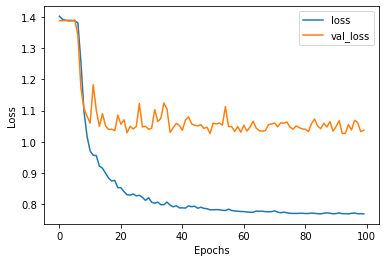

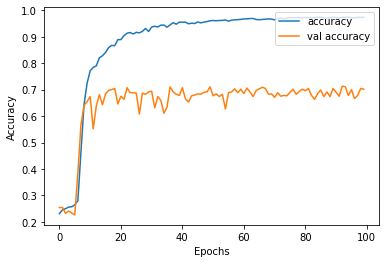

In [10]:
plot_learning_curve(history)

In [11]:
test_x = tokenizer(
    text=test['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y=ytest
)

21/21 [==============================] - ETA: 0s - loss: 1.0213 - accuracy: 0.71 - ETA: 0s - loss: 1.1102 - accuracy: 0.62 - ETA: 0s - loss: 1.0682 - accuracy: 0.66 - ETA: 0s - loss: 1.0660 - accuracy: 0.66 - ETA: 0s - loss: 1.0677 - accuracy: 0.67 - ETA: 0s - loss: 1.0731 - accuracy: 0.66 - ETA: 0s - loss: 1.0883 - accuracy: 0.64 - ETA: 0s - loss: 1.0840 - accuracy: 0.65 - ETA: 0s - loss: 1.0857 - accuracy: 0.64 - ETA: 0s - loss: 1.0675 - accuracy: 0.66 - ETA: 0s - loss: 1.0757 - accuracy: 0.65 - 7s 314ms/step - loss: 1.0757 - accuracy: 0.6594


In [12]:
model_eval

[1.075716495513916, 0.6594090461730957]

In [13]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(prediction)]